## Goal: Обучите классификатор, предсказывающий категорию объявления на Авито по его заголовку, описанию и цене. Метрика для оценки качества -- accuracy. Необходимо предоставить прокомментированный код (желательно на Python 2.x или 3.x, можно в Jupiter Notebook) для всех этапов решения задачи и результат скоринга файла test.csv с помощью предложенного классификатора (csv-файл с двумя столбцами: item_id, category_id).

##### Категории имеют иерархическую структуру, описанную в файле сategory.csv. Посчитайте также accuracy вашей модели на каждом уровне иерархии.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
import re
from multiprocessing import Pool
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from nltk.probability import FreqDist
from nltk import word_tokenize
import pymorphy2
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
#from tqdm import tqdm_notebook as tqdm
#tqdm().pandas()

# Data load

In [2]:
train = pd.read_csv('train.csv')
train.sample(10)

,item_id,title,description,price,category_id
184625,184625,Чехол для iPhone 5/5s (чехол для айфона),В наличии чехлы для iPhone 5/5s с Катей Самбук...,100.0,9
69133,69133,Люстра подвесная Luce Solara 5053/5P,Продам подвесную люстру. Длина подвеса регулир...,2450.0,28
222288,222288,Чехол lifeproof FRE для iPhone 6S plus,— Lifeproof-store - самый большой выбор оригин...,6399.0,9
417926,417926,Сапоги DolceGabbana Оригинал,Сапоги выгуливались пару раз. Состояние идеаль...,10000.0,39
187657,187657,Радиола Муромец,Продается радиола Муромец в рабочем состоянии,4500.0,44
151307,151307,Ботинки горнолыжные Salomon,Продам отличные горнолыжные ботинки Salomon. К...,5900.0,42
440423,440423,"Телевизор 24"" (61см) LCD TCL новый гарантия",Телевизор 24 LCD TCL L24E4104FR новый гарантия...,10000.0,5
47694,47694,Бесплатная доставка по России,Качественное и красивое постельное белье из по...,1890.0,27
433258,433258,Фиалка ле-Карусель,Продаются детки сортовой фиалки ЛЕ-Карусель. Н...,100.0,24
287334,287334,Двухъядерный комьютер Athlon 64 X2 3600+ / 2Gb...,Двухъядерный процессор AMD Athlon 64 X2 3600+ ...,4900.0,7


In [3]:
train.shape

(489517, 5)

In [4]:
train.describe()

,item_id,price,category_id
count,489517.000000,4.895170e+05,489517.000000
mean,244758.000000,8.795970e+03,26.765361
std,141311.530199,7.158194e+04,15.531774
min,0.000000,1.300000e+01,0.000000
25%,122379.000000,7.500000e+02,13.000000
50%,244758.000000,2.400000e+03,27.000000
75%,367137.000000,7.000000e+03,40.000000
max,489516.000000,1.000000e+07,53.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489517 entries, 0 to 489516
Data columns (total 5 columns):
item_id        489517 non-null int64
title          489517 non-null object
description    489517 non-null object
price          489517 non-null float64
category_id    489517 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 18.7+ MB


In [6]:
test = pd.read_csv('test.csv')
test.sample(10)

,item_id,title,description,price
180596,670113,Продам коляску,"Продам недорого немецкую коляску зима-лето, в ...",3500.0
101033,590550,Накладка на Sony Xperia Z1 compact,"Отличное состояние, как новый. Фирма cherry Те...",150.0
8483,498000,Стульчик для кормления Chicco Polly,"Стульчик в отличном состоянии,ремни в комплект...",4500.0
173326,662843,Фиолетовая толстовка из флиса L/XL на молнии н...,фиолетовая толстовка из флиса L/XL на молнии с...,500.0
167332,656849,HP EliteBook 2540p,Продаю за ненадобностью. Отличный бизнес-ноутб...,13000.0
101092,590609,Отрез голубой ткани,"Качественный хлопок, СССР, подойдет для шитья ...",200.0
145268,634785,Корейский,Русско-корейский разговорник. Состояние хорошее,70.0
55031,544548,Samsung-Galaxy S4,Продам Оригинал ОЗУ 2 Гб RAM 16 камера 13 Si...,8500.0
68573,558090,Бронируем Абхазию из Ижевска,"АБХАЗИЯ(СУХУМ) вылет 5 июня из ИЖЕВСКА, 8 дней...",23000.0
87195,576712,Айфон 5,"Айфон 5, белый ,16 Гб. пару трещин на экране ...",7000.0


In [7]:
test.shape

(243166, 4)

In [8]:
category = pd.read_csv('category.csv')
category.sample(10)

,category_id,name
36,36,Личные вещи|Часы и украшения|Часы
21,21,Для дома и дачи|Ремонт и строительство|Сантехн...
35,35,"Личные вещи|Одежда, обувь, аксессуары|Женская ..."
4,4,"Бытовая электроника|Игры, приставки и программ..."
8,8,"Бытовая электроника|Игры, приставки и программ..."
43,43,Хобби и отдых|Книги и журналы|Книги
24,24,Для дома и дачи|Растения
51,51,Хобби и отдых|Книги и журналы|Учебная литература
41,41,Личные вещи|Товары для детей и игрушки|Товары ...
30,30,Личные вещи|Товары для детей и игрушки|Игрушки


In [9]:
category.shape

(54, 2)

# Data overview

In [10]:
len(train.item_id.unique())

489517

In [11]:
train.category_id.unique()

array([19, 22, 37, 43,  1, 50, 41, 36, 48, 39, 30, 34, 46, 28, 24, 17, 32,
       38, 51, 18, 14,  5,  4,  2, 33, 20, 13, 49,  8, 11, 53, 21, 25, 42,
       40, 31, 12, 44, 23,  6,  7,  0, 15, 27, 29, 52,  3,  9, 16, 35, 47,
       45, 26, 10], dtype=int64)

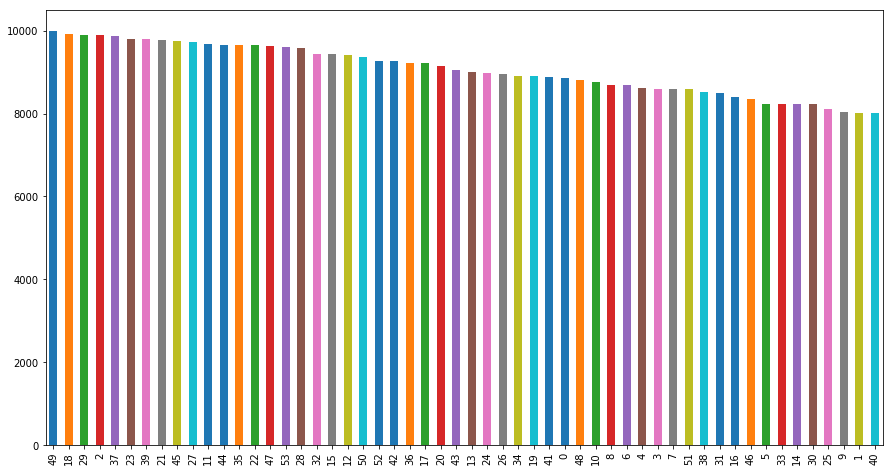

In [12]:
fig = plt.gcf() 
fig.set_size_inches(15,8)
train.category_id.value_counts().plot('bar')

### Pretty balanced classes

In [13]:
category.name.apply(lambda x: len(x.split('|'))).values

array([3, 2, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 3], dtype=int64)

### Not all of categories have 3 levels
### Split them for the future

In [14]:
category['1st_level'] = category.name.apply(lambda x: x.split('|')[0])
category['2nd_level'] = category.name.apply(lambda x: x.split('|')[1])
category['3rd_level'] = category.name.apply(lambda x: x.split('|')[2] if len(x.split('|'))>2 else 0)
category['4th_level'] = category.name.apply(lambda x: x.split('|')[3] if len(x.split('|'))>3 else 0)

In [15]:
category.sample(10)

,category_id,name,1st_level,2nd_level,3rd_level,4th_level
22,22,Для дома и дачи|Мебель и интерьер|Столы и стулья,Для дома и дачи,Мебель и интерьер,Столы и стулья,0
21,21,Для дома и дачи|Ремонт и строительство|Сантехн...,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,0
49,49,Хобби и отдых|Охота и рыбалка,Хобби и отдых,Охота и рыбалка,0,0
29,29,Для дома и дачи|Бытовая техника|Для кухни|Мелк...,Для дома и дачи,Бытовая техника,Для кухни,Мелкая кухонная техника
39,39,"Личные вещи|Одежда, обувь, аксессуары|Женская ...",Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь
37,37,Личные вещи|Красота и здоровье|Приборы и аксес...,Личные вещи,Красота и здоровье,Приборы и аксессуары,0
25,25,Для дома и дачи|Ремонт и строительство|Двери,Для дома и дачи,Ремонт и строительство,Двери,0
8,8,"Бытовая электроника|Игры, приставки и программ...",Бытовая электроника,"Игры, приставки и программы",Игры для приставок,0
52,52,Хобби и отдых|Музыкальные инструменты|Для студ...,Хобби и отдых,Музыкальные инструменты,Для студии и концертов,0
27,27,Для дома и дачи|Мебель и интерьер|Текстиль и к...,Для дома и дачи,Мебель и интерьер,Текстиль и ковры,0


# Preprocessing
### I assume that we should lowercase the text and remove the punctuation

In [16]:
train.title = train.title.apply(lambda x: re.sub(r'\s+', ' ', re.sub(r'[^\w\s]',' ', x.lower().replace('-', ' ')).strip()))
train.description = train.description.apply(lambda x: re.sub(r'\s+', ' ', re.sub(r'[^\w\s]',' ', x.lower().replace('-', ' ')).strip()))
train.sample(10)

,item_id,title,description,price,category_id
202012,202012,cisco me 3400 24ts ac,габаритные размеры вхшхг 44 5 см x 4 5 см x 23...,7000.0,14
357372,357372,зимние женские сапоги,черного цвета снаружи иск замша внутри иск мех...,600.0,39
213393,213393,шкаф купе,шкаф купе двухдверный изготовлен из лдсп высок...,8550.0,18
184351,184351,продаю абсолютно новую мультиварку maxwell mw 380,продаю абсолютно новую не распакованная в целл...,1900.0,29
487023,487023,смесь frisolac1,сухая адаптированная смесь для детского питани...,200.0,41
28218,28218,каркас кровати хемнэс с реечным дном,продам б у каркас кровати с реечным дном состо...,8000.0,16
367769,367769,колье серебро бирюза жемчуг,продам авторское колье из серебра природной би...,3000.0,40
347465,347465,доминикана 16 01 на 12дн из мск,кабарет cabarete beach house at nanny estates ...,62900.0,48
229005,229005,праздничный тур в волгоград 06 05 09 05 16,в стоимость включено проезд проживание питание...,7400.0,48
271331,271331,кровать чердак,продам кровать чердак для ребёнка с матрацем в...,8000.0,23


In [17]:
test.title = test.title.apply(lambda x: re.sub(r'\s+', ' ', re.sub(r'[^\w\s]',' ', x.lower().replace('-', ' ')).strip()))
test.description = test.description.apply(lambda x: re.sub(r'\s+', ' ', re.sub(r'[^\w\s]',' ', x.lower().replace('-', ' ')).strip()))
test.sample(10)

,item_id,title,description,price
23365,512882,шкатулки,шкатулка из змеевика,1700.0
40621,530138,высокая ваза с декоративными цветами,высокая ваза с декоративными цветами смотрится...,2000.0
102351,591868,для массажа второе сердце nuga best nm 55р,в аппарате второе сердце объединены контрастны...,21000.0
39620,529137,спортивная резина для workout,резиновые петли разной жесткости широко примен...,900.0
148542,638059,продам бритва philips,продам бритву philips в отличном состоянии исп...,3000.0
183452,672969,учебник краеведение,две части 1я и 3я каждая по 100 р,100.0
235288,724805,iphone 6s 16gb gold ростест неактивированный,продам айфон 6s 16gb золотого цвета телефон аб...,46000.0
13589,503106,пароварка,продается пароварка выглядит как новая готовил...,800.0
196903,686420,монитор lg,lg v k8810hfnr в хорошем состоянии,1000.0
13196,502713,комод,продам комод в хорошем состоянии 4 ящика ширин...,1700.0


### Let's look at the length distribution

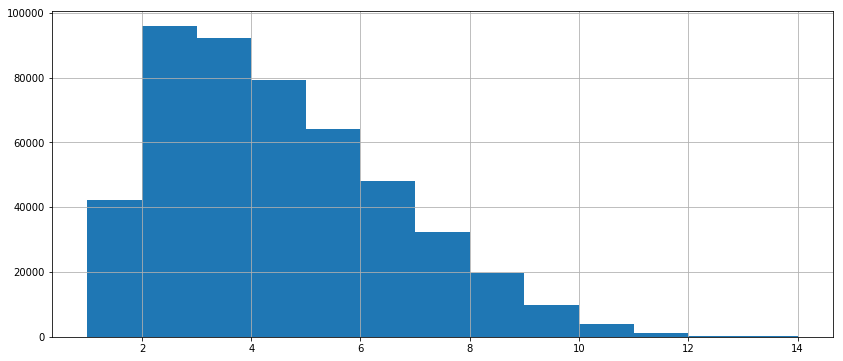

In [18]:
# for train.title
lengths = train.title.apply(lambda x: len(x.split()))
lengths.hist(bins = np.arange(start=1, stop=15, step=1), figsize=[14,6])

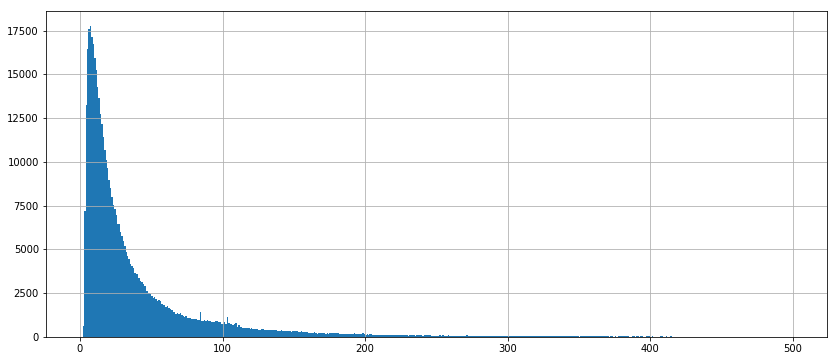

In [19]:
# for train.text
lengths = train.description.apply(lambda x: len(x.split()))
lengths.hist(bins = np.arange(start=1, stop=500, step=1), figsize=[14,6])

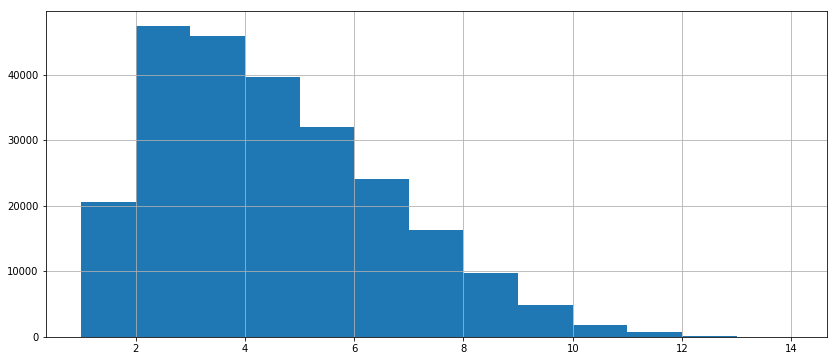

In [20]:
# for test.title
lengths = test.title.apply(lambda x: len(x.split()))
lengths.hist(bins = np.arange(start=1, stop=15, step=1), figsize=[14,6])

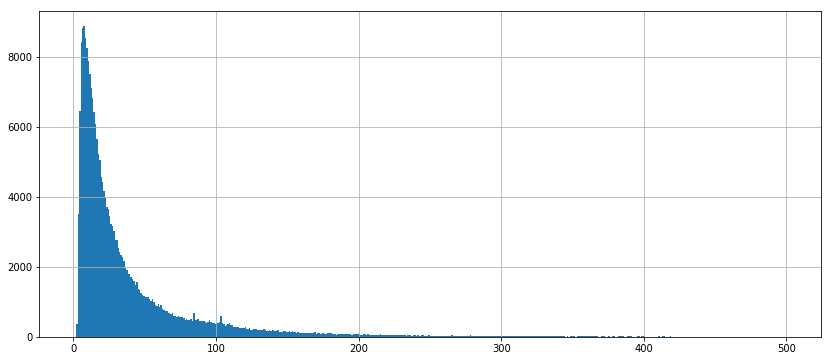

In [21]:
# for test.text
lengths = test.description.apply(lambda x: len(x.split()))
lengths.hist(bins = np.arange(start=1, stop=500, step=1), figsize=[14,6])

### Remove russian stopwords (from nltk.corpus) and lemmatize the words, did it only once, then saved results

In [22]:
morph = pymorphy2.MorphAnalyzer()

In [23]:
def morph_prepr(text):
    words = [morph.parse(i)[0].normalized.word for i in text.split(' ')]
    words = [x for x in words if x not in nltk_stopwords.words('russian') and x!='\n']
    text = " ".join(words)
    return text

In [24]:
def pre_apply(texts):
    pre = texts.apply(lambda x: morph_prepr(x))
    return pre

In [25]:
def parallelize(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data
cores = 20
partitions = cores

In [26]:
#%%time
#preprocessed = parallelize(train['title'], pre_apply)
#train['title'] = preprocessed.values
#train.head(10)

In [27]:
#%%time
#preprocessed = parallelize(train['description'], pre_apply)
#train['description'] = preprocessed.values
#train.head(10)

In [28]:
#%%time
#preprocessed = parallelize(test['title'], pre_apply)
#test['title'] = preprocessed.values
#test.head(10)

In [29]:
#%%time
#preprocessed = parallelize(test['description'], pre_apply)
#test['description'] = preprocessed.values
#test.head(10)

In [30]:
#train.to_csv("train_preprocessed.csv", index=None)
#test.to_csv("test_preprocessed.csv", index=None)

In [2]:
train_old = pd.read_csv('train.csv')
train_old.sample(10)

,item_id,title,description,price,category_id
45364,45364,Матрица для ноутбука LTN156AT24 B01,Матрица для ноутбука LTN156AT24 B01; Диагональ...,2850.0,13
471907,471907,Дрель,В отличном состоянии.,1500.0,17
196961,196961,Часы GF Ferre оригинал,"Потрясающе красивые,элитные часы.",17000.0,36
256947,256947,Детская кроватка с матрацем и бортиками,Кроватка с матрацем и бортиками в отличном сос...,3500.0,34
353200,353200,Вещьмишок,"Вещь Мишок, 90 литров , брал за 6000₽ звонить ...",4000.0,49
227176,227176,Ковры. Хит-сет. Мозайка. 2082b3. 1.6х2.3м. Вит...,══════════════════════════════════════­­­═ В...,4328.0,27
212230,212230,Защита usd pro,Защита колено-голень размер s/m Катана сезон,1500.0,53
92059,92059,Кагуль,"Оплечье с капюшоном из объемной пряжи, очень т...",1800.0,31
204006,204006,Игра Гарри Поттер и Принц полукровка для PS3,Игра Гарри Поттер и Принц полукровка для PS3 ...,250.0,8
301458,301458,Табурет,4 табуретки в отличном состоянии. Торг уместен.,1000.0,22


In [2]:
train = pd.read_csv('train_preprocessed.csv')
train.sample(10)

,item_id,title,description,price,category_id
201047,201047,стол книжка,стол книжка среднее состояние очень дёшево,350.0,22
156482,156482,велокомпьютер 8 13111060 cat10 10 функция author,велокомпьютер 8 13111060 cat10 10 функция auth...,1640.0,53
10578,10578,одеяло новое 2х спальный наполнитель халафа йбер,новое одеяло новое 2х спальный наполнитель хал...,1700.0,27
126029,126029,медицинский прибор элитон,автономный физиотерапевтический многофункциона...,1000.0,37
80429,80429,продать коляска трость,продать коляска трость подходить девочка мальч...,800.0,32
198510,198510,системный блок intel celeron cpu 430 1 80ghz 775,продать системный блок процессор intel celeron...,2000.0,7
353492,353492,прихожая,мебель прихожая хороший состояние шкаф шкаф по...,1500.0,18
36912,36912,doogee f3 pro новый,продавать android смартфон doogee f3 pro хорош...,10900.0,6
383724,383724,большой набор база щенячийпатруль арт 9 4 8l1o,люба желать поcетить большой офис спасатель pa...,4931.0,30
12906,12906,детский комната,школьный уголок омег 6 производство год волжск...,16200.0,23


In [3]:
test_old = pd.read_csv('test.csv')
test = pd.read_csv('test_preprocessed.csv')
test.sample(10)

,item_id,title,description,price
228201,717718,тренажёр,продать тренажёр хороший состояние,14000.0
212002,701519,продать светильник 2206 6 odeon,светильник подвесной артикул 2206 6 новый запе...,16318.0
188844,678361,туфля замшевый,продать туфля темно синий цвет замшевый отличн...,350.0
59554,549071,франческо петрарка сочинение,франческо петрарка сочинение москва издательст...,100.0
50266,539783,демисезонный сапог р р 38,б хороший состояние нат кожа удобный каблук го...,1000.0
143418,632935,фирменный посуда малышок,продать отличный набор посуда божий коровка ме...,600.0
22067,511584,bq aspen mini yellow новый,совершенно новый телефон год гарантия момент п...,2500.0
13997,503514,led tv samsung ue40j6200 40 102см,телевизор samsung ue40j6200 40 102см характери...,29500.0
62525,552042,таиланд районг доплата,вылет 31 март 8 день nice beach 2 завтрак 473 ...,36800.0
224207,713724,детский стульчик кормление 3 1,продать детский стульчик кормление 3 1 использ...,1500.0


In [5]:
train[(train.description.apply(type) != str)]

,item_id,title,description,price,category_id
87749,87749,usb wifi адаптер,NaN,350.0,14
114855,114855,продавать мебель плетёнка,NaN,10000.0,16
142792,142792,педаль новое,NaN,400.0,53
266145,266145,замена батарейка часы ала фаджр,NaN,100.0,36
332338,332338,перчатка,NaN,1000.0,31


In [6]:
print(*[train_old.description[x] for x in train[(train.description.apply(type) != str)].index], sep='\n')

............................
......................................................................
......... .............
....................
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [7]:
print(*[train_old.title[x] for x in train[(train.description.apply(type) != str)].index], sep='\n')

Usb WiFi адаптер
Продаю мебель плетенка
Педали новые
Замена батарейки на часы Ал-фаджр
Перчатки


### Interesting description

In [8]:
train[(train.title.apply(type) != str)]

,item_id,title,description,price,category_id
6314,6314,NaN,светильник настольный camelion лампа накаливан...,900.0,23
44422,44422,NaN,очень интересный неожиданный сюжет,1000.0,8
98969,98969,NaN,пока видеть объявление оно актуально,1800.0,8
142503,142503,NaN,диск отличный состояние эксклюзив playstation ...,800.0,8
143093,143093,NaN,хороший состояние полностью рабочий подходить ...,1000.0,3
150908,150908,NaN,продать игра ps4 отличный состояние цена оконч...,1000.0,8
154005,154005,NaN,3том издательство метр педагогика 1975г твёрды...,1500.0,43
165702,165702,NaN,1988г 365страница это сборник открывать библио...,90.0,43
194992,194992,NaN,купить август 2015 весь пройти данный момент п...,1000.0,8
205354,205354,NaN,отличный игра хороший игра десятилетие обмен н...,700.0,8


In [9]:
print(*[train_old.title[x] for x in train[(train.title.apply(type) != str)].index], sep='\n')

Другое
Одни из нас
Одни из нас
Одни из нас
Другой
Одни из нас
Что такое Кто такой
"Ты и я"
Один из нас
Одни из нас
Один из нас
Одни из нас
Будет только у Вас
Другое
Третий
Одни из нас
Один из нас
Одни из нас
Одни из нас
Три в одном
Другое
Одни из нас


In [4]:
train = train.fillna(' ')
test = test.fillna(' ')

### After preprocessing

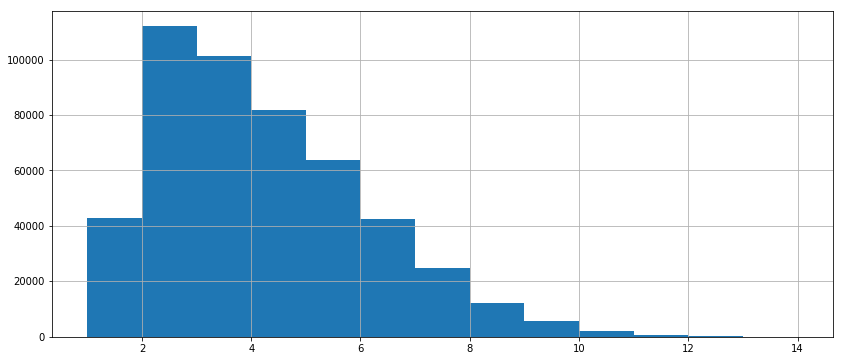

In [11]:
# for title
lengths = train.title.apply(lambda x: len(x.split()))
lengths.hist(bins = np.arange(start=1, stop=15, step=1), figsize=[14,6])

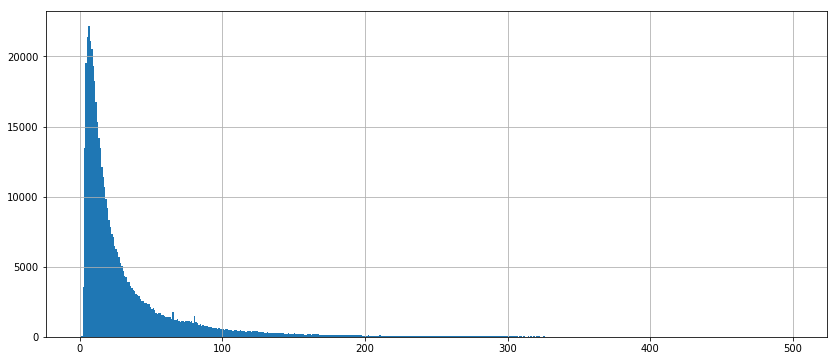

In [12]:
# for descriprion
lengths = train.description.apply(lambda x: len(x.split()))
lengths.hist(bins = np.arange(start=1, stop=500, step=1), figsize=[14,6])

### Сreate a custom stopword list and exclude useless frequent words

In [13]:
#fdist_title = FreqDist((' '.join(train.title.values)).split(' '))

In [14]:
#fdist_description = FreqDist((' '.join(train.description.values)).split(' '))

In [15]:
#fdist_title.most_common(200)

In [16]:
#fdist_description.most_common(200)

In [5]:
file = open('stopwords.txt')
stopwords = file.read().strip().split()
file.close()

In [6]:
def remove_stopwords(text):
    return ' '.join(filter(lambda x: x not in stopwords, text.split()))

In [7]:
train.title = train.title.apply(remove_stopwords)

In [8]:
train.description = train.description.apply(remove_stopwords)
train.sample(10)

,item_id,title,description,price,category_id
189881,189881,системный блок,часть целиком стоить целый торгом,10000.0,7
29924,29924,керамогранить ардезия светло коричневый 41 8х4...,тд lunaventый предлагать огромный ассортимент ...,650.0,15
94811,94811,чайрик походный 7л,чайник алюминиевый 7л,300.0,20
209930,209930,модульный dj контроллер reloop contour controller,смс коробка диск провод юзать модульный контро...,8000.0,52
214788,214788,диван,обивка жизнь яркий фото ящик бельё,3000.0,16
217826,217826,силиконовый кейс iphone 6s арт 00377,удобный кейс выполнить силикон оригинальный ри...,390.0,9
49318,49318,кухонный уголок,кухонный уголок подходить маленькая кухня лёгк...,2000.0,23
143150,143150,sony experia z,заводский комплект inst luckystooore подписчик...,11000.0,11
344780,344780,йогуртница,йогуртница supra йогурт грамм,350.0,29
348267,348267,блок питание bp v12 600 мощность вт,данный тип конструкция светодиодный модуль обл...,1185.0,28


In [9]:
test.title = test.title.apply(remove_stopwords)
test.description = test.description.apply(remove_stopwords)
test.sample(10)

,item_id,title,description,price
166266,655783,sony xperia z1,пользоваться аккуратно коробка документ иметься,10000.0
48858,538375,лий детский коробка,атакж большой выбор детский товар низкий,990.0
82267,571784,ламинат,знаете нужно готовый дать низкий ламинат выбра...,320.0
21187,510704,чехол meizu m2 mini,абсолютно силиконовый чехол бампер,150.0
2669,492186,штанга,штанга фирма atlet barbell общий вес килограмм...,6000.0
125722,615239,бампер iphone 5s металлический,бампер металлический iphone 5s металлический а...,250.0
108459,597976,журнальный столик,старый журнальный столик,500.0
88715,578232,проигрыватель илга 301,проигрыватель илга 301 колонка,5000.0
128764,618281,уф лампа 36 вт,ультрафиолетовый лампа 36 вт номинальный напря...,700.0
162177,651694,копейка 1952,копейка 1952 отправить почта копейка 1955 1956...,100.0


### Divide train to test results

In [11]:
train_, test_ = train_test_split(train, test_size = 0.2, random_state = 10)

# Bag of words + classic ML

In [30]:
count_vectorizer_title = CountVectorizer(analyzer="word", min_df=0.001).fit(train_['title'])
count_vectorizer_description = CountVectorizer(analyzer="word", min_df=0.001).fit(train_['description'])

In [31]:
print(len(count_vectorizer_title.get_feature_names()))
len(count_vectorizer_description.get_feature_names())

471


3458

In [32]:
first_feature = count_vectorizer_title.transform(train_['title']).toarray()
second_feature = count_vectorizer_description.transform(train_['description']).toarray()
first_feature_test = count_vectorizer_title.transform(test_['title']).toarray()
second_feature_test = count_vectorizer_description.transform(test_['description']).toarray()

In [33]:
x_train = np.concatenate([first_feature, second_feature], axis=1)
x_test = np.concatenate([first_feature_test, second_feature_test], axis=1)
y_train = train_['category_id']
y_test = test_['category_id']

In [34]:
%%time
cls_RF = RandomForestClassifier(n_jobs=-1, random_state = 10, class_weight = 'balanced').fit(x_train, y_train)
y_pred_random_forest = cls_RF.predict(x_test) 

Wall time: 5min


In [35]:
print("Accuracy score: {:5f}".format(metrics.accuracy_score(y_test, y_pred_random_forest)))

Accuracy score: 0.773656


### Make predictions

In [10]:
count_vectorizer_title = CountVectorizer(analyzer="word", min_df=0.001).fit(train['title'])
count_vectorizer_description = CountVectorizer(analyzer="word", min_df=0.001).fit(train['description'])

In [11]:
first_feature = count_vectorizer_title.transform(train['title']).toarray()
second_feature = count_vectorizer_description.transform(train['description']).toarray()
first_feature_test = count_vectorizer_title.transform(test['title']).toarray()
second_feature_test = count_vectorizer_description.transform(test['description']).toarray()

In [12]:
x_train = np.concatenate([first_feature, second_feature], axis=1)
x_test = np.concatenate([first_feature_test, second_feature_test], axis=1)
y_train = train['category_id']

In [13]:
%%time
cls_RF = RandomForestClassifier(n_jobs=-1, random_state = 10, class_weight = 'balanced').fit(x_train, y_train)
y_pred_random_forest = cls_RF.predict(x_test) 

Wall time: 6min 21s


In [18]:
pd.DataFrame({'item_id': test.item_id.values, 'category_id': y_pred_random_forest}).to_csv('predictions.csv', index = None)

#### Random Forest is usually good for texts 

#### One-vs-Rest and One-vs-One + LinearSVC

In [18]:
#y_pred_OVO_SVC = OneVsOneClassifier(LinearSVC(class_weight = 'balanced'), n_jobs = -1).fit(x_train, y_train).predict(x_test) 

In [19]:
#print("Accuracy score: {:5f}".format(metrics.accuracy_score(y_test, y_pred_OVO_SVC)))

In [20]:
#y_pred_OVR_SVC = OneVsRestClassifier(LinearSVC(class_weight = 'balanced')).fit(x_train, y_train).predict(x_test) 

In [21]:
#print("Accuracy score: {:5f}".format(metrics.accuracy_score(y_test, y_pred_OVR_SVC)))

#### Tfidf + LinearSVC

In [12]:
tfidf_vectorizer_title = TfidfVectorizer(analyzer="word", min_df=0.001).fit(train_['title'])
tfidf_vectorizer_description = TfidfVectorizer(analyzer="word", min_df=0.001).fit(train_['description'])

In [14]:
first_feature = tfidf_vectorizer_title.transform(train_['title']).toarray()
second_feature = tfidf_vectorizer_description.transform(train_['description']).toarray()
first_feature_test = tfidf_vectorizer_title.transform(test_['title']).toarray()
second_feature_test = tfidf_vectorizer_description.transform(test_['description']).toarray()

In [15]:
x_train = np.concatenate([first_feature, second_feature], axis=1)
x_test = np.concatenate([first_feature_test, second_feature_test], axis=1)
y_train = train_['category_id']
y_test = test_['category_id']

In [ ]:
#y_pred_OVR_SVC = OneVsRestClassifier(LinearSVC(class_weight = 'balanced')).fit(x_train, y_train).predict(x_test) 

In [ ]:
#print("Accuracy score: {:5f}".format(metrics.accuracy_score(y_test, y_pred_OVR_SVC)))

In [16]:
%%time
cls_RF = RandomForestClassifier(n_jobs=-1, random_state = 10, class_weight = 'balanced').fit(x_train, y_train)
y_pred_random_forest = cls_RF.predict(x_test) 

Wall time: 4min 48s


In [17]:
print("Accuracy score: {:5f}".format(metrics.accuracy_score(y_test, y_pred_random_forest)))

Accuracy score: 0.777670


In [22]:
#SVC_pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
#                         ('clf', OneVsRestClassifier(LinearSVC(class_weighted = 'balanced', verbose = True),))])
#SVC_pipeline.fit(x_train, y_train)
#y_pred = SVC_pipeline.predict(x_test)

In [23]:
#print("Accuracy score: {:5f}".format(metrics.accuracy_score(y_test, y_pred)))

### Simple model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.layers import LSTM

C:\Users\HK\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
title_max = 150
descr_max = 350
# preprocess
categories = to_categorical(train.category_id, num_classes=54)
title_tok = Tokenizer(num_words=title_max)
title_tok.fit_on_texts(train.title)
title_mat_texts = title_tok.texts_to_matrix(train.title, mode = 'count')
descr_tok = Tokenizer(num_words=descr_max)
descr_tok.fit_on_texts(train.description)
descr_mat_texts = descr_tok.texts_to_matrix(train.description, mode = 'count')
mat_texts = np.hstack((title_mat_texts,descr_mat_texts))

In [12]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(descr_max+title_max,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(54, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               256512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 54)                13878     
Total params: 401,718
Trainable params: 401,718
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(mat_texts,categories, epochs=50, batch_size=32,validation_split=0.2)

Train on 391613 samples, validate on 97904 samples
Epoch 1/50
391613/391613 [==============================] - 70s 178us/step - loss: 1.3546 - acc: 0.6382 - val_loss: 1.2055 - val_acc: 0.6702
Epoch 2/50
391613/391613 [==============================] - 68s 174us/step - loss: 1.2136 - acc: 0.6668 - val_loss: 1.1830 - val_acc: 0.6739
Epoch 3/50
391613/391613 [==============================] - 68s 174us/step - loss: 1.1711 - acc: 0.6756 - val_loss: 1.1794 - val_acc: 0.6776
Epoch 4/50
391613/391613 [==============================] - 70s 179us/step - loss: 1.1426 - acc: 0.6813 - val_loss: 1.1738 - val_acc: 0.6786
Epoch 5/50
391613/391613 [==============================] - 69s 177us/step - loss: 1.1242 - acc: 0.6863 - val_loss: 1.1777 - val_acc: 0.6776
Epoch 6/50
391613/391613 [==============================] - 69s 176us/step - loss: 1.1101 - acc: 0.6890 - val_loss: 1.1794 - val_acc: 0.6797
Epoch 7/50
391613/391613 [==============================] - 69s 176us/step - loss: 1.0971 - acc: 0.6922

KeyboardInterrupt: 

In [ ]:
model.save(SAVE_PATH + 'ads.h5')

### Simple LSTM (tried snn but it was too bad)

In [48]:
max_words = 1000
title_max_len = 150
title_tok = Tokenizer(num_words=max_words)
title_tok.fit_on_texts(train.title)
title_sequences = title_tok.texts_to_sequences(train.title)
title_sequences_matrix = sequence.pad_sequences(title_sequences,maxlen=title_max_len)
descr_max_len = 250
descr_tok = Tokenizer(num_words=max_words)
descr_tok.fit_on_texts(train.description)
descr_sequences = title_tok.texts_to_sequences(train.description)
descr_sequences_matrix = sequence.pad_sequences(descr_sequences,maxlen=descr_max_len)
mat_texts = np.hstack((title_sequences_matrix,descr_sequences_matrix))

In [51]:
model = Sequential()
model.add(Embedding(max_words,50,input_length=400))
model.add(LSTM(64))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(54))
model.add(Activation('softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 400, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 54)                13878     
_________________________________________________________________
activation_6 (Activation)    (None, 54)                0         
Total para

In [58]:
history = model.fit(mat_texts,categories, epochs=50, batch_size=256, validation_split=0.2)

Train on 391613 samples, validate on 97904 samples
Epoch 1/50
391613/391613 [==============================] - 1440s 4ms/step - loss: 1.4414 - acc: 0.6209 - val_loss: 1.2989 - val_acc: 0.6501
Epoch 2/50
258560/391613 [==================>...........] - ETA: 7:50 - loss: 1.3258 - acc: 0.6447

KeyboardInterrupt: 

In [ ]:
model.save(SAVE_PATH + 'ads.h5')

In [ ]:
predictions = model.predict(test_text)

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 20+1)

plt.figure(figsize=(14,8))

plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Train LSTM model in Google Colab on GPU, 69% val_accuracy

### TO DO
- по левинштейну исправлять опечатки
- давать больше вес title
- использовать цену